In [14]:
# Top2Vec Tweet Modeling Pipeline

# 1. Setup and Imports
!pip install top2vec pysentimiento pandas matplotlib seaborn wordcloud umap-learn --quiet

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from top2vec import Top2Vec
from pysentimiento.preprocessing import preprocess_tweet


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [15]:
def save_figure(fig, name, folder="figures"):
    os.makedirs(folder, exist_ok=True)
    fig.savefig(os.path.join(folder, f"{name}.png"), bbox_inches='tight')


In [31]:
def plot_wordclouds(model, top_n=3):
    topic_words, word_scores, topic_nums = model.get_topics()
    for topic_num, words in zip(topic_nums[:top_n], topic_words[:top_n]):
        scores = word_scores[topic_num]
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(words, scores)))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for Topic {topic_num}")
        save_figure(plt.gcf(), f"wordcloud_topic_{topic_num}")
        plt.show()


In [28]:
def plot_wordclouds(model, top_n=3):
    for topic_num in range(top_n):
        words, scores = model.get_topic_words(topic_num, num_words=30)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(words, scores)))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for Topic {topic_num}")
        save_figure(plt.gcf(), f"wordcloud_topic_{topic_num}")
        plt.show()

In [52]:

def visualize_documents(model):
    print("Generating document UMAP visualization from scratch...")
    import umap
    from sklearn.preprocessing import normalize
    import matplotlib.pyplot as plt

    # no need to check hasattr, we'll call get_documents and vectorize them
    documents = model.documents
    doc_embeddings = model.embed(documents)

    
    doc_topics = model.doc_top

    reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
    embeddings_2d = reducer.fit_transform(normalize(doc_embeddings))

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=doc_topics, cmap="tab10", s=10, alpha=0.7)
    plt.colorbar(scatter, label="Topic")
    plt.title("Top2Vec Document Embeddings (UMAP)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(True)
    plt.show()


In [58]:
def plot_topic_trend_over_time(df_posts, model):
    print("Plotting topic distribution over time...")
    df = df_posts.copy()
    df['topic'] = model.doc_top
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    df = df.dropna(subset=['created_at'])
    df['month'] = df['created_at'].dt.to_period('M')
    grouped = df.groupby(['month', 'topic']).size().reset_index(name='count')
    pivot_df = grouped.pivot(index='month', columns='topic', values='count').fillna(0)

    pivot_df.plot(figsize=(14, 6))
    plt.title('Topic Frequency Over Time')
    plt.xlabel('Month')
    plt.ylabel('Number of Documents')
    plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [69]:

def plot_stacked_topic_trends(df, topic_columns):
    import matplotlib.cm as cm
    import numpy as np
    print("Plotting stacked topic trends over time...")
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    df['month'] = df['created_at'].dt.to_period('M').dt.to_timestamp()
    monthly_topics = df.groupby('month')[topic_columns].sum()
    colors = cm.tab20(np.linspace(0, 1, monthly_topics.shape[1]))
    monthly_topics.plot(kind='area', stacked=True, figsize=(14, 8), alpha=0.85, color=colors)
    plt.title("Topic Trends Over Time")
    plt.xlabel("Month")
    plt.ylabel("Topic Count")
    plt.tight_layout()
    plt.show()

In [70]:
import sqlite3



def main():
    # 2. Load Data from SQLite database
    db_path = "New_Fire_DB.db"
    conn = sqlite3.connect(db_path)
    # Print table structure to debug available columns
    print("Available columns in 'posts' table:")
    table_info = pd.read_sql_query("PRAGMA table_info(posts);", conn)
    print(table_info[['name', 'type']])
    query = "SELECT tweet_id, user_screen_name AS author, full_text AS content, user_verified AS label, created_at FROM posts WHERE full_text IS NOT NULL LIMIT 10000;"
    df_posts = pd.read_sql_query(query, conn)
    conn.close()

    # 3. Preprocess Content
    df_posts["clean_content"] = df_posts["content"].apply(preprocess_tweet)

    # 4. Train Top2Vec
    print("Training Top2Vec model...")
    model = Top2Vec(documents=df_posts["clean_content"].tolist(), speed="learn", embedding_model="distiluse-base-multilingual-cased", keep_documents=True, document_ids=df_posts["tweet_id"].tolist())

    # 6. Run Visualizations
    df_posts["created_at"] = pd.to_datetime(df_posts["created_at"], errors='coerce')
    plot_topic_sizes(model)
    plot_wordclouds(model)
    visualize_documents(model)
    plot_topic_trend_over_time(df_posts, model)

    # Generate Top2Vec built-in black background wordclouds
    _, topic_nums = model.get_topic_sizes()
    for topic in topic_nums[1:9]:
        model.generate_topic_wordcloud(topic, background_color="black")

    # Optional: Save the model

    # Generate one-hot encoded topic columns
    for topic_id in set(model.doc_top):
        df_posts[f'topic_{topic_id}'] = (model.doc_top == topic_id).astype(int)

    # Plot stacked topic trends over time
    topic_columns = [col for col in df_posts.columns if col.startswith('topic_')]
    plot_stacked_topic_trends(df_posts, topic_columns)

    # model.save("top2vec_model")




Available columns in 'posts' table:
                    name     type
0               tweet_id  INTEGER
1                    url     TEXT
2        conversation_id  INTEGER
3             created_at     TEXT
4              full_text     TEXT
5                   lang     TEXT
6             is_retweet  INTEGER
7               is_reply  INTEGER
8          retweet_count  INTEGER
9         favorite_count  INTEGER
10           reply_count  INTEGER
11           quote_count  INTEGER
12        bookmark_count  INTEGER
13    possibly_sensitive  INTEGER
14              hashtags     TEXT
15         user_mentions     TEXT
16               user_id  INTEGER
17             user_name     TEXT
18      user_screen_name     TEXT
19         user_location     TEXT
20       user_created_at     TEXT
21      user_description     TEXT
22  user_followers_count  INTEGER
23    user_friends_count  INTEGER
24   user_statuses_count  INTEGER
25         user_verified  INTEGER
26    user_profile_image     TEXT


2025-05-12 13:25:29,003 - top2vec - INFO - Pre-processing documents for training


Training Top2Vec model...


/home/edennar/.conda/envs/env_project/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-05-12 13:25:29,570 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
2025-05-12 13:25:31,544 - top2vec - INFO - Creating joint document/word embedding
2025-05-12 13:25:36,061 - top2vec - INFO - Creating lower dimension embedding of documents
2025-05-12 13:25:42,291 - top2vec - INFO - Finding dense areas of documents
2025-05-12 13:25:42,536 - top2vec - INFO - Finding topics
/tmp/ipykernel_841020/1423805328.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_posts["created_at"] = pd.to_datetime(df_posts["created_at"], errors='coerce')


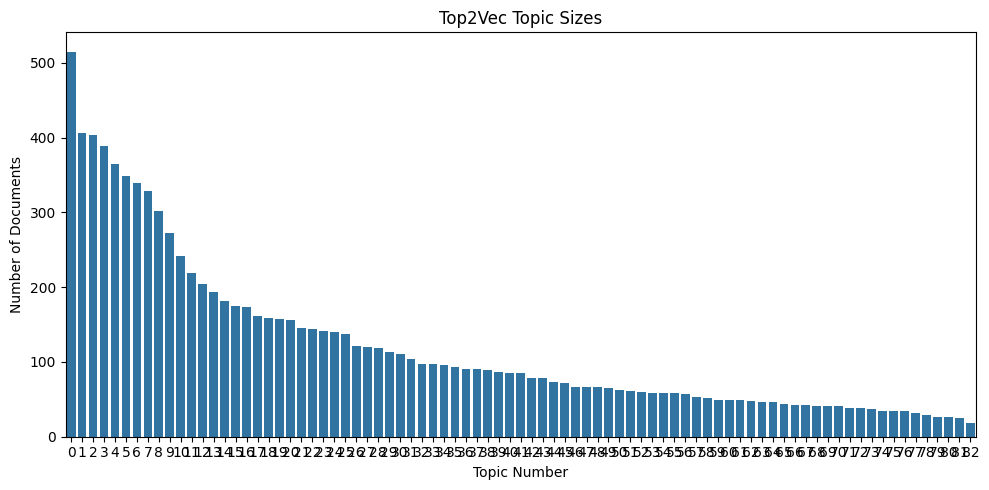

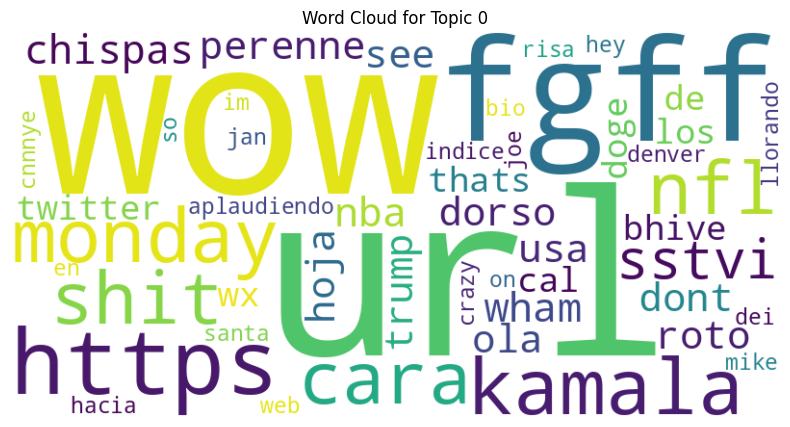

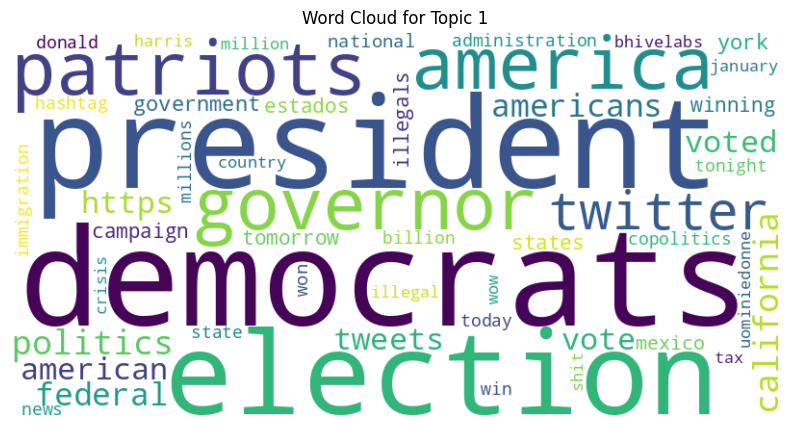

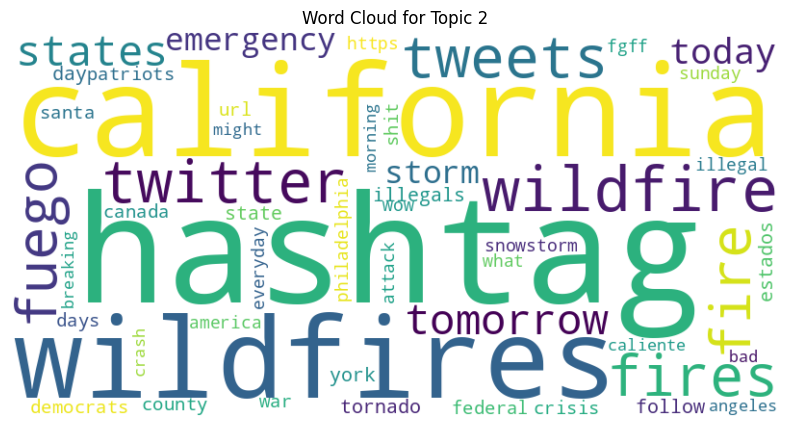

Generating document UMAP visualization from scratch...


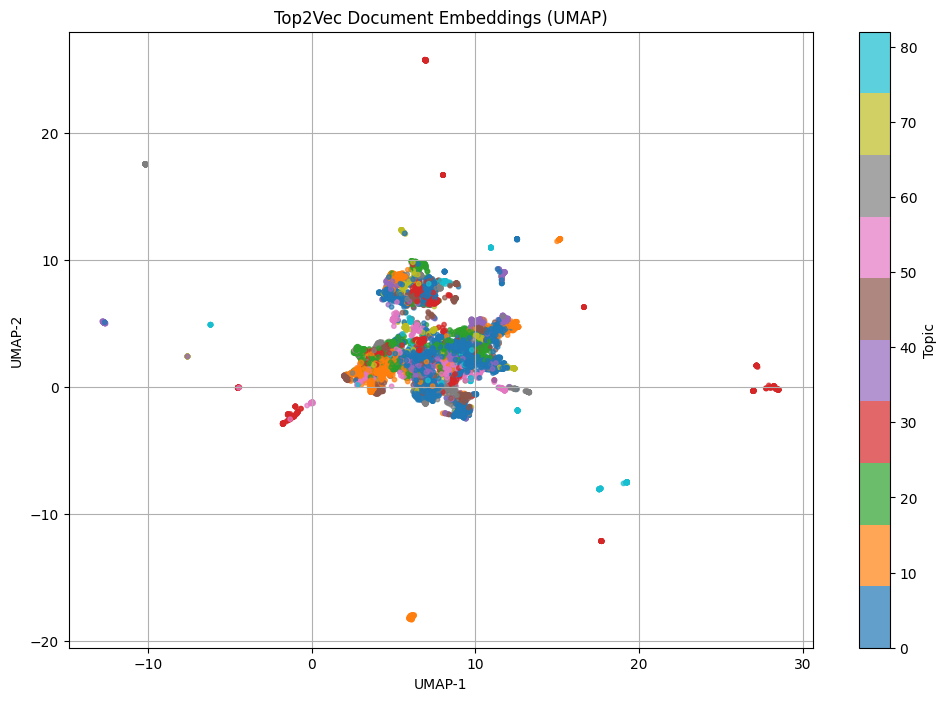

Plotting topic distribution over time...


/tmp/ipykernel_841020/3564291731.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['created_at'].dt.to_period('M')
/tmp/ipykernel_841020/3564291731.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


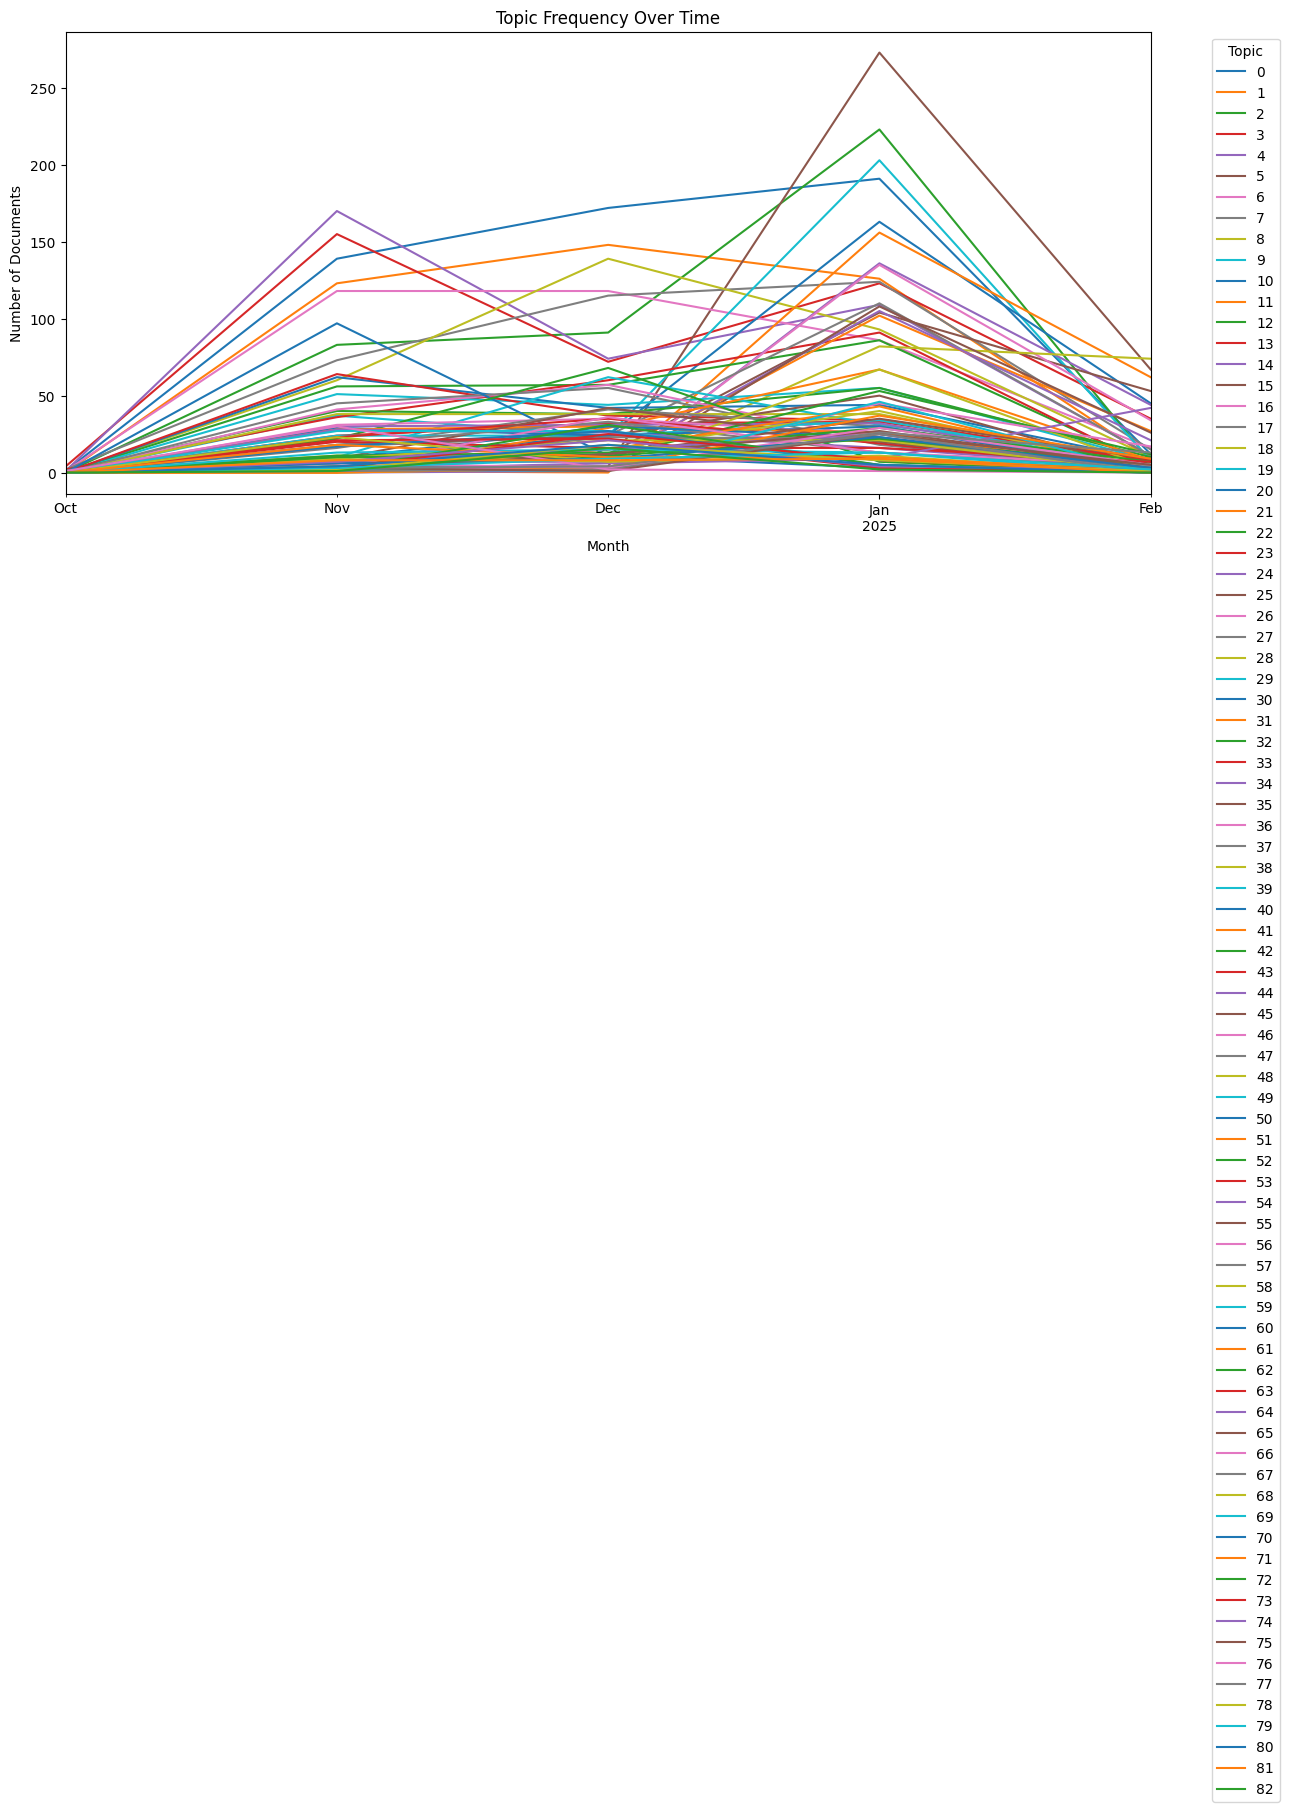

Plotting stacked topic trends over time...


/tmp/ipykernel_841020/3456618217.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['created_at'].dt.to_period('M').dt.to_timestamp()
/tmp/ipykernel_841020/3456618217.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


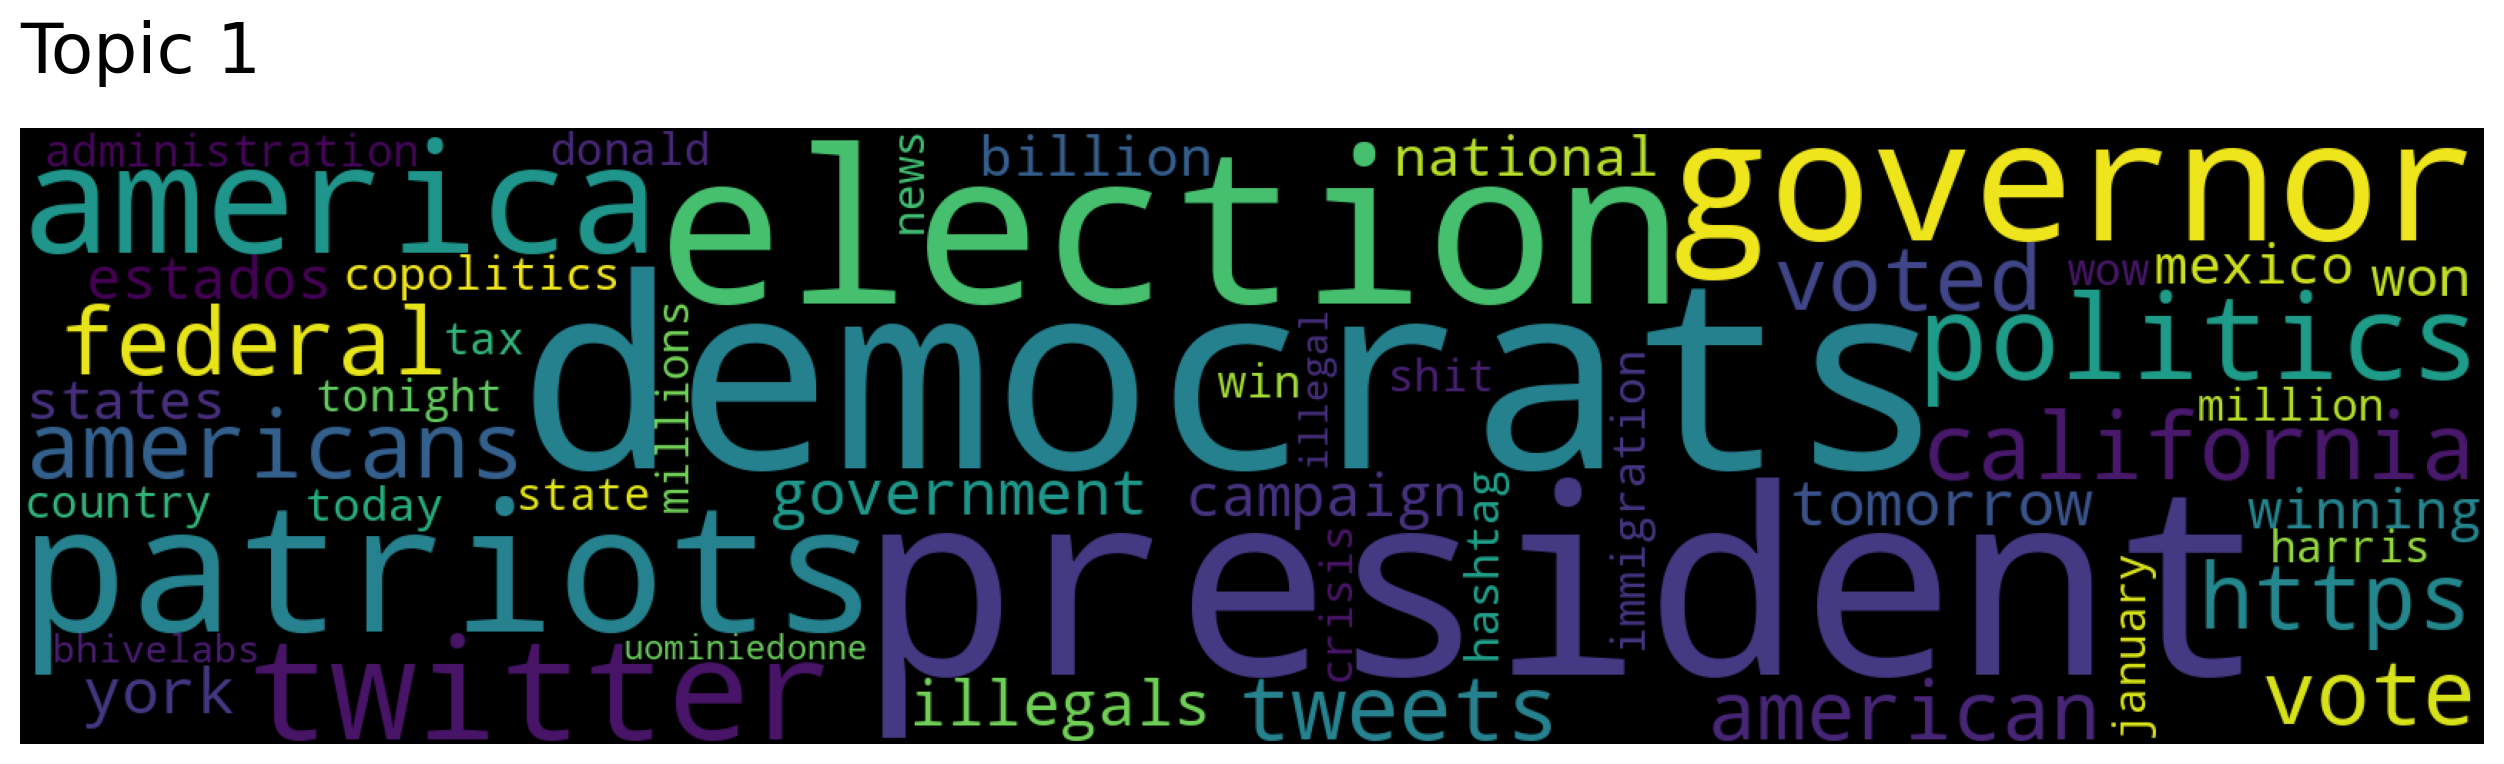

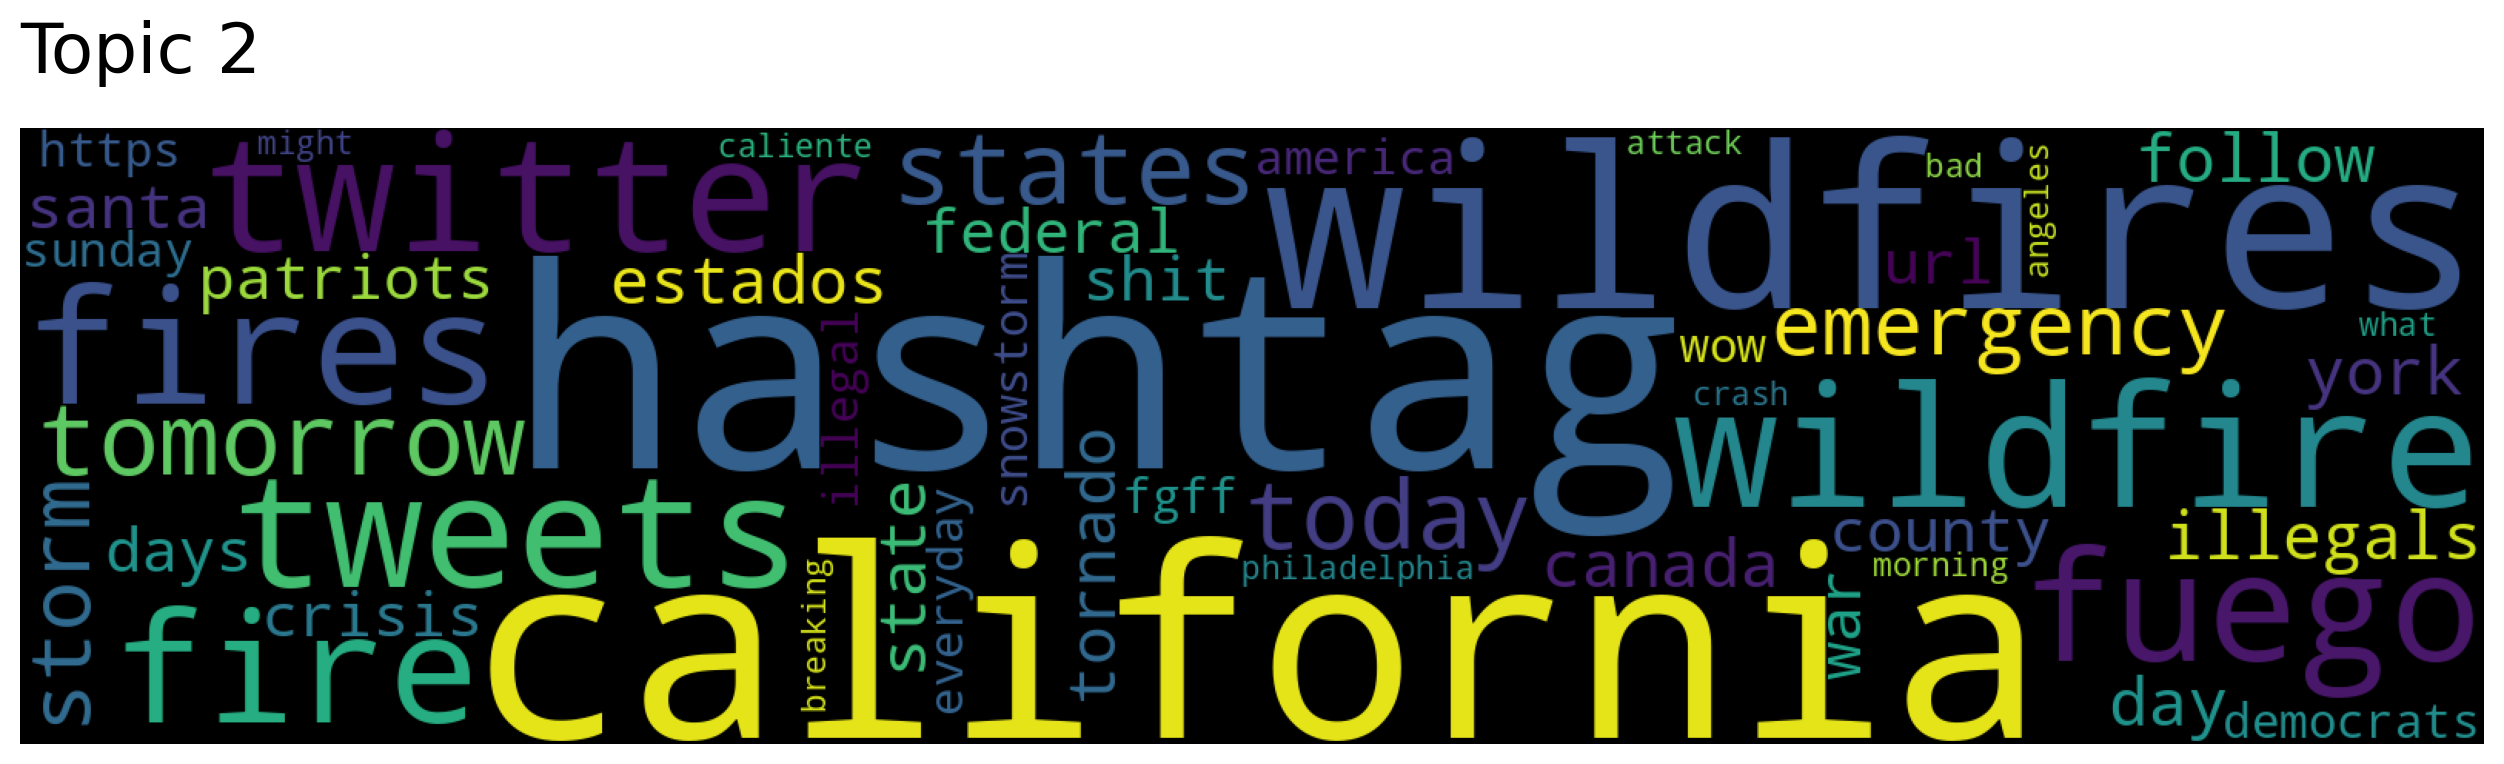

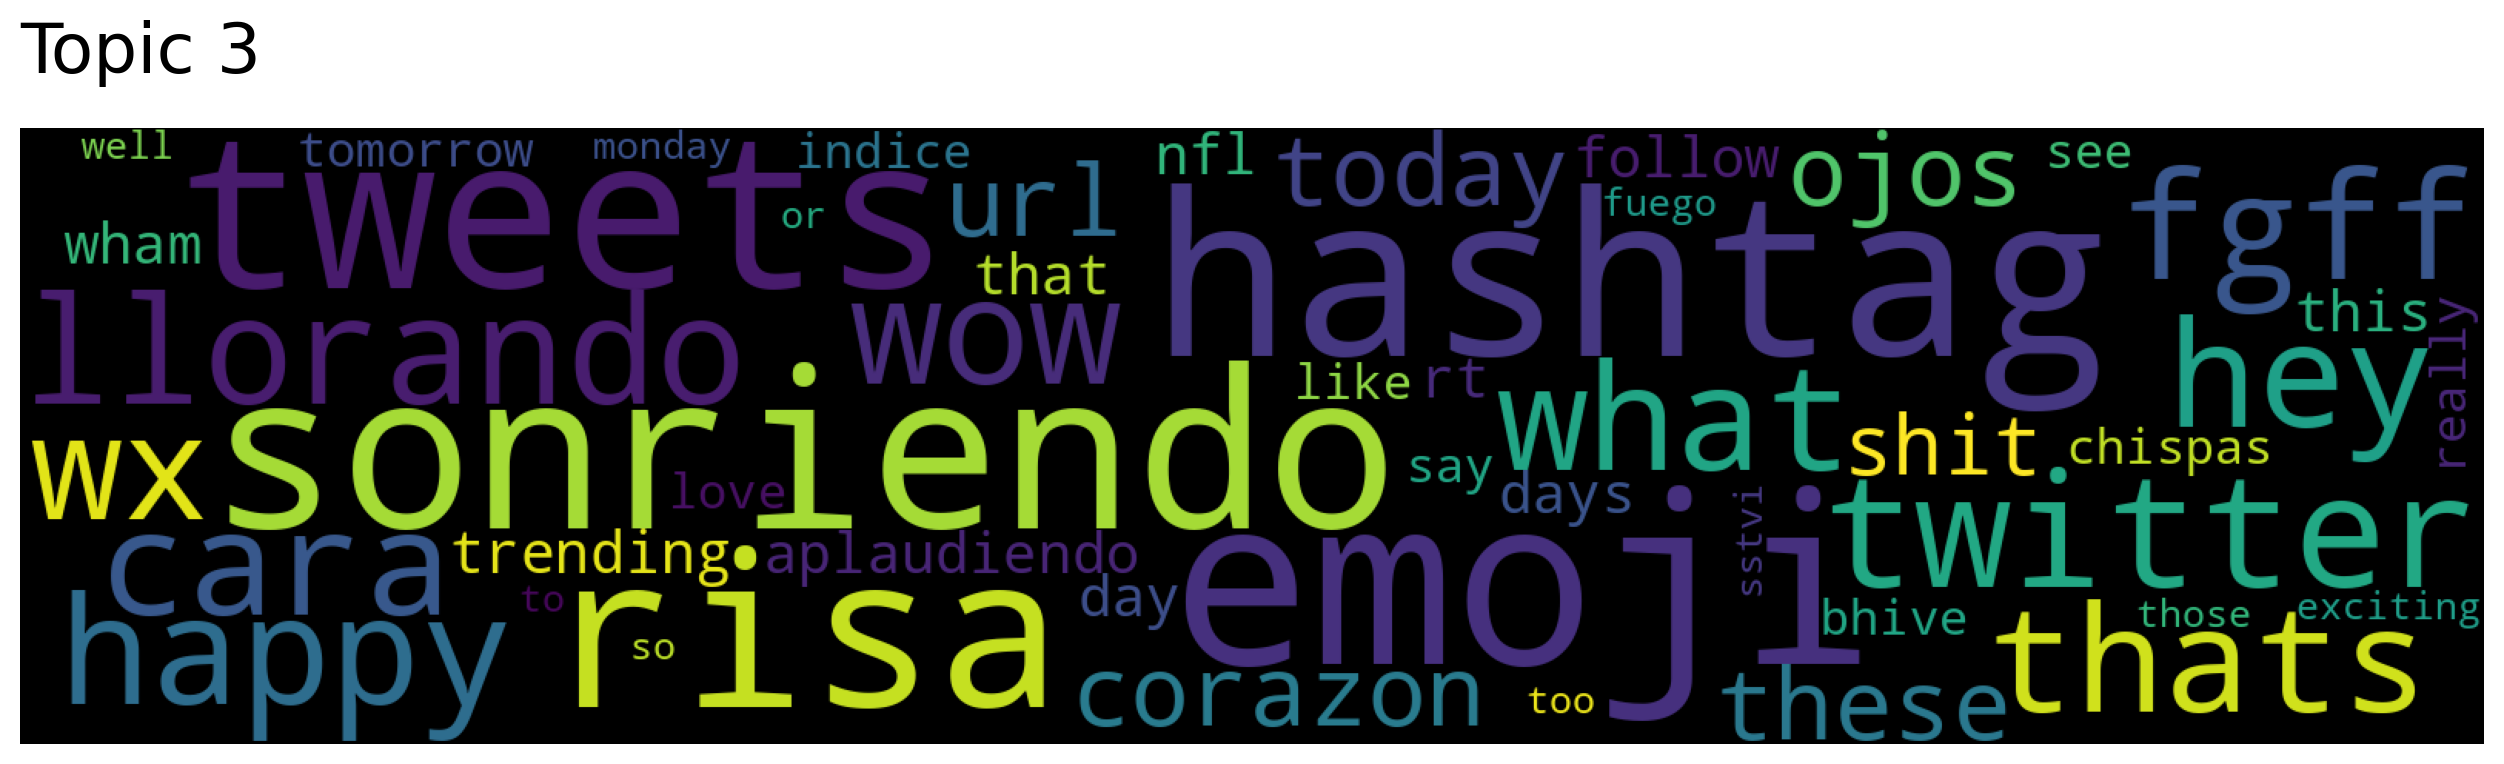

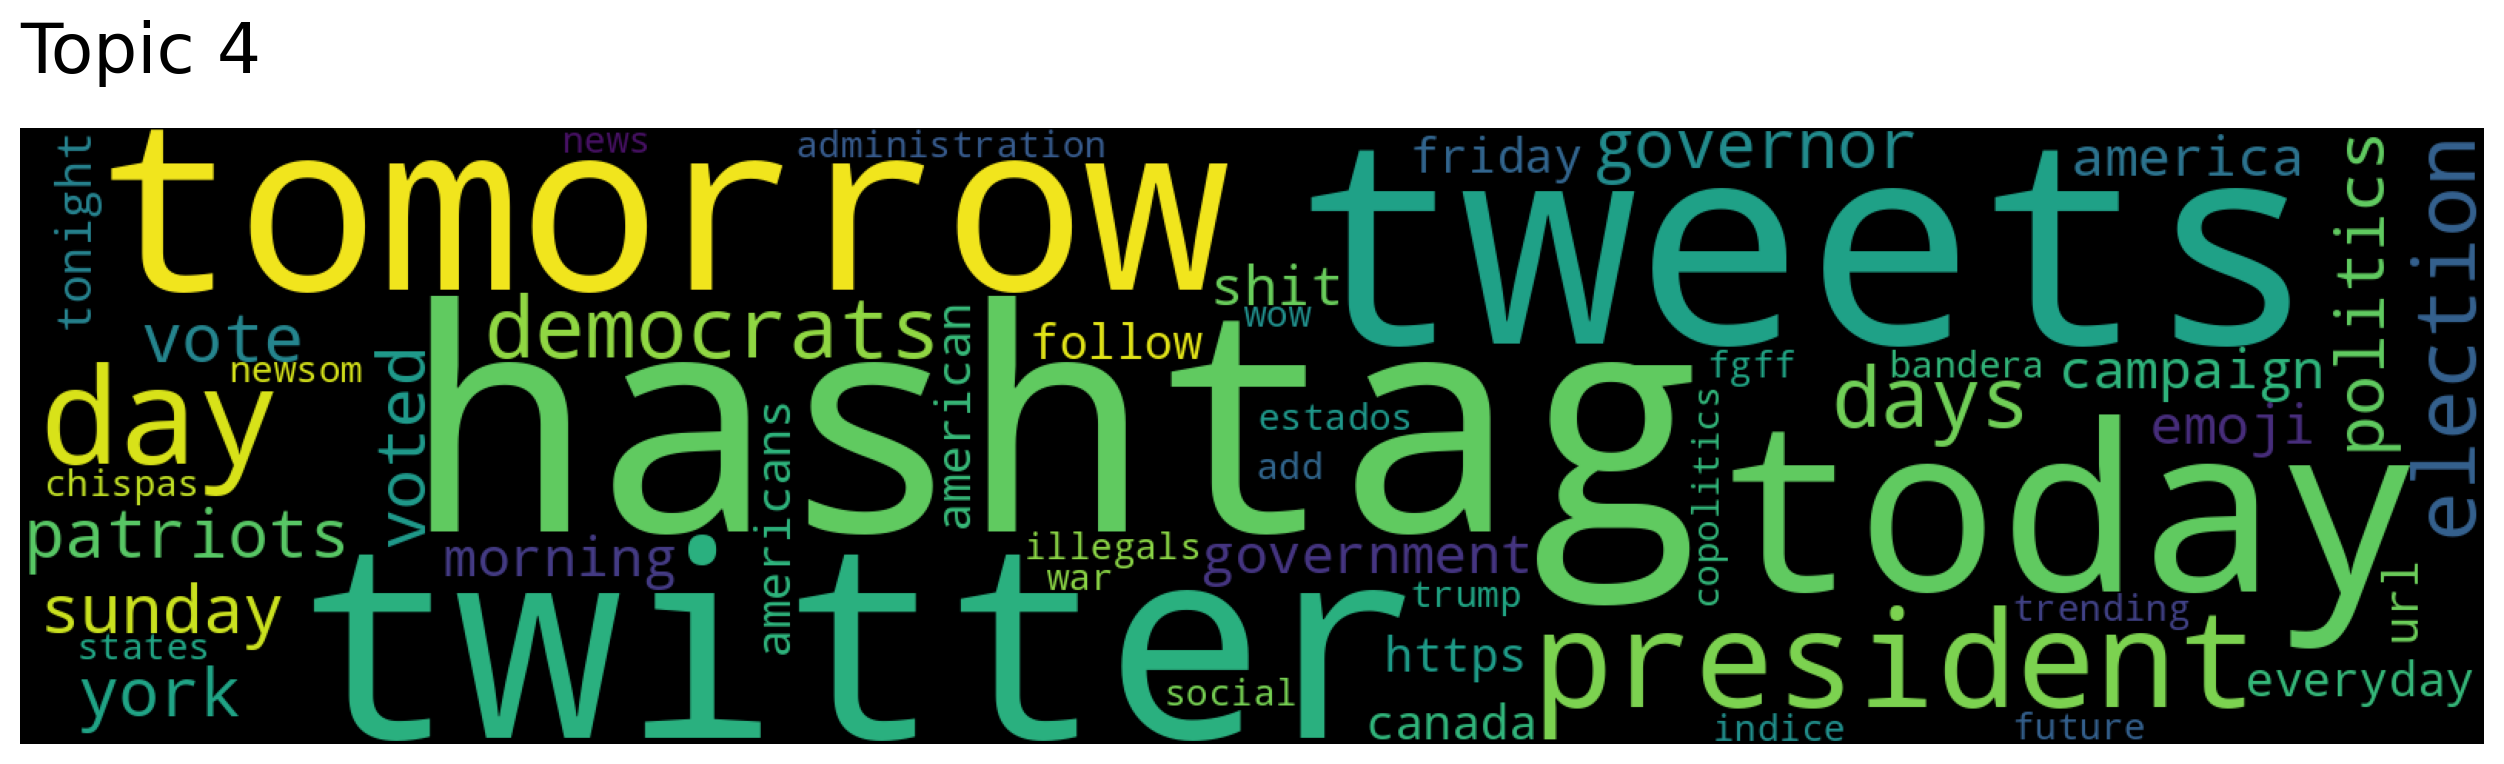

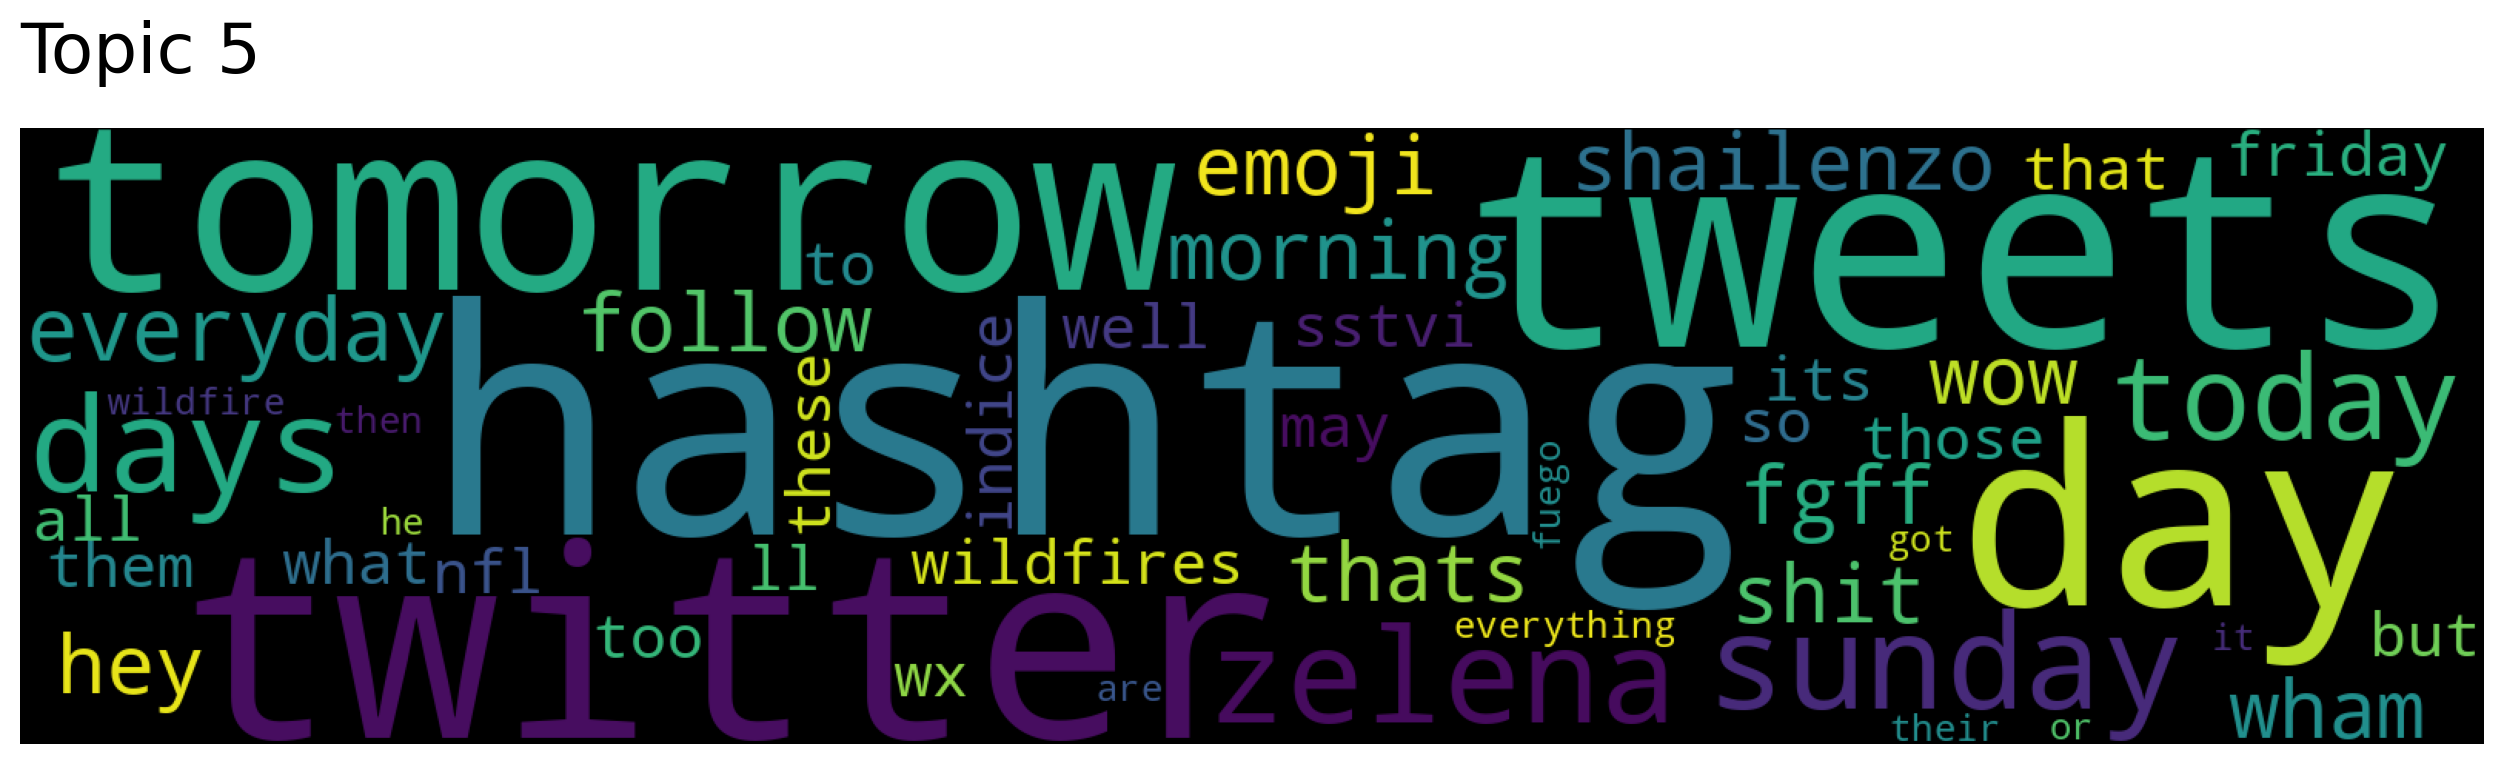

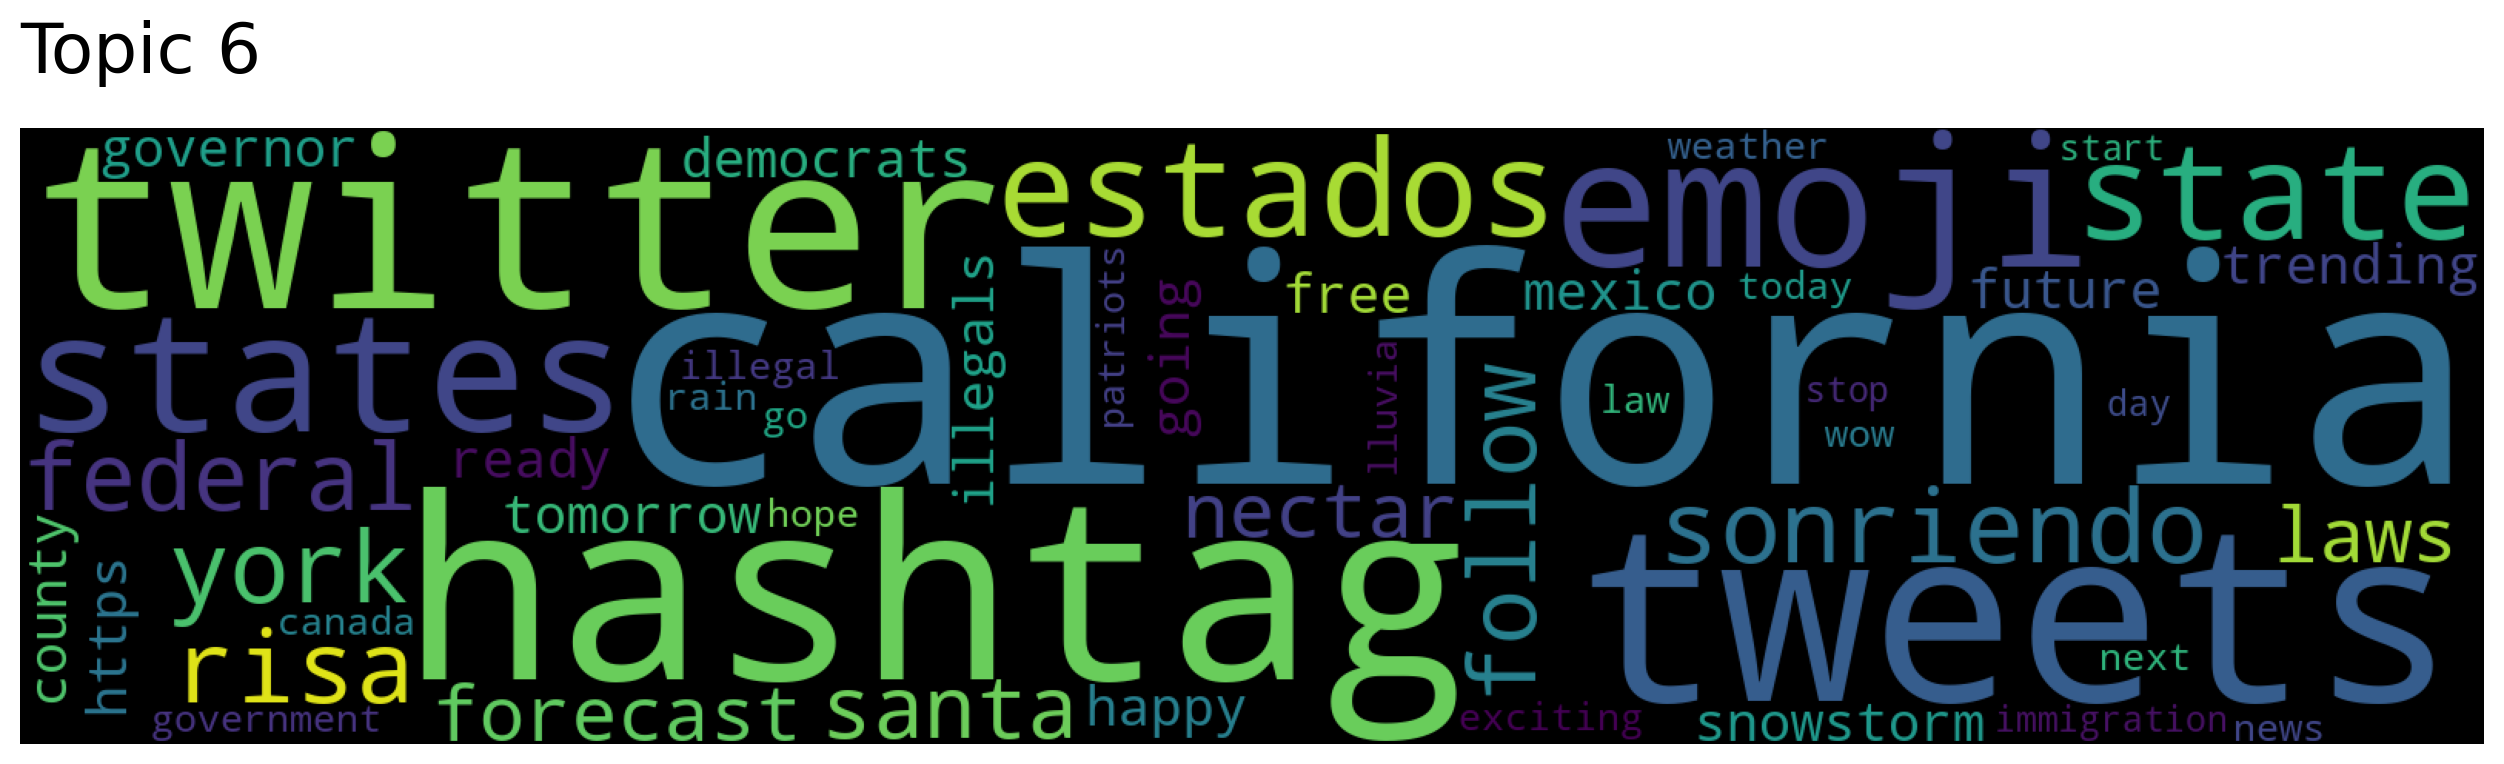

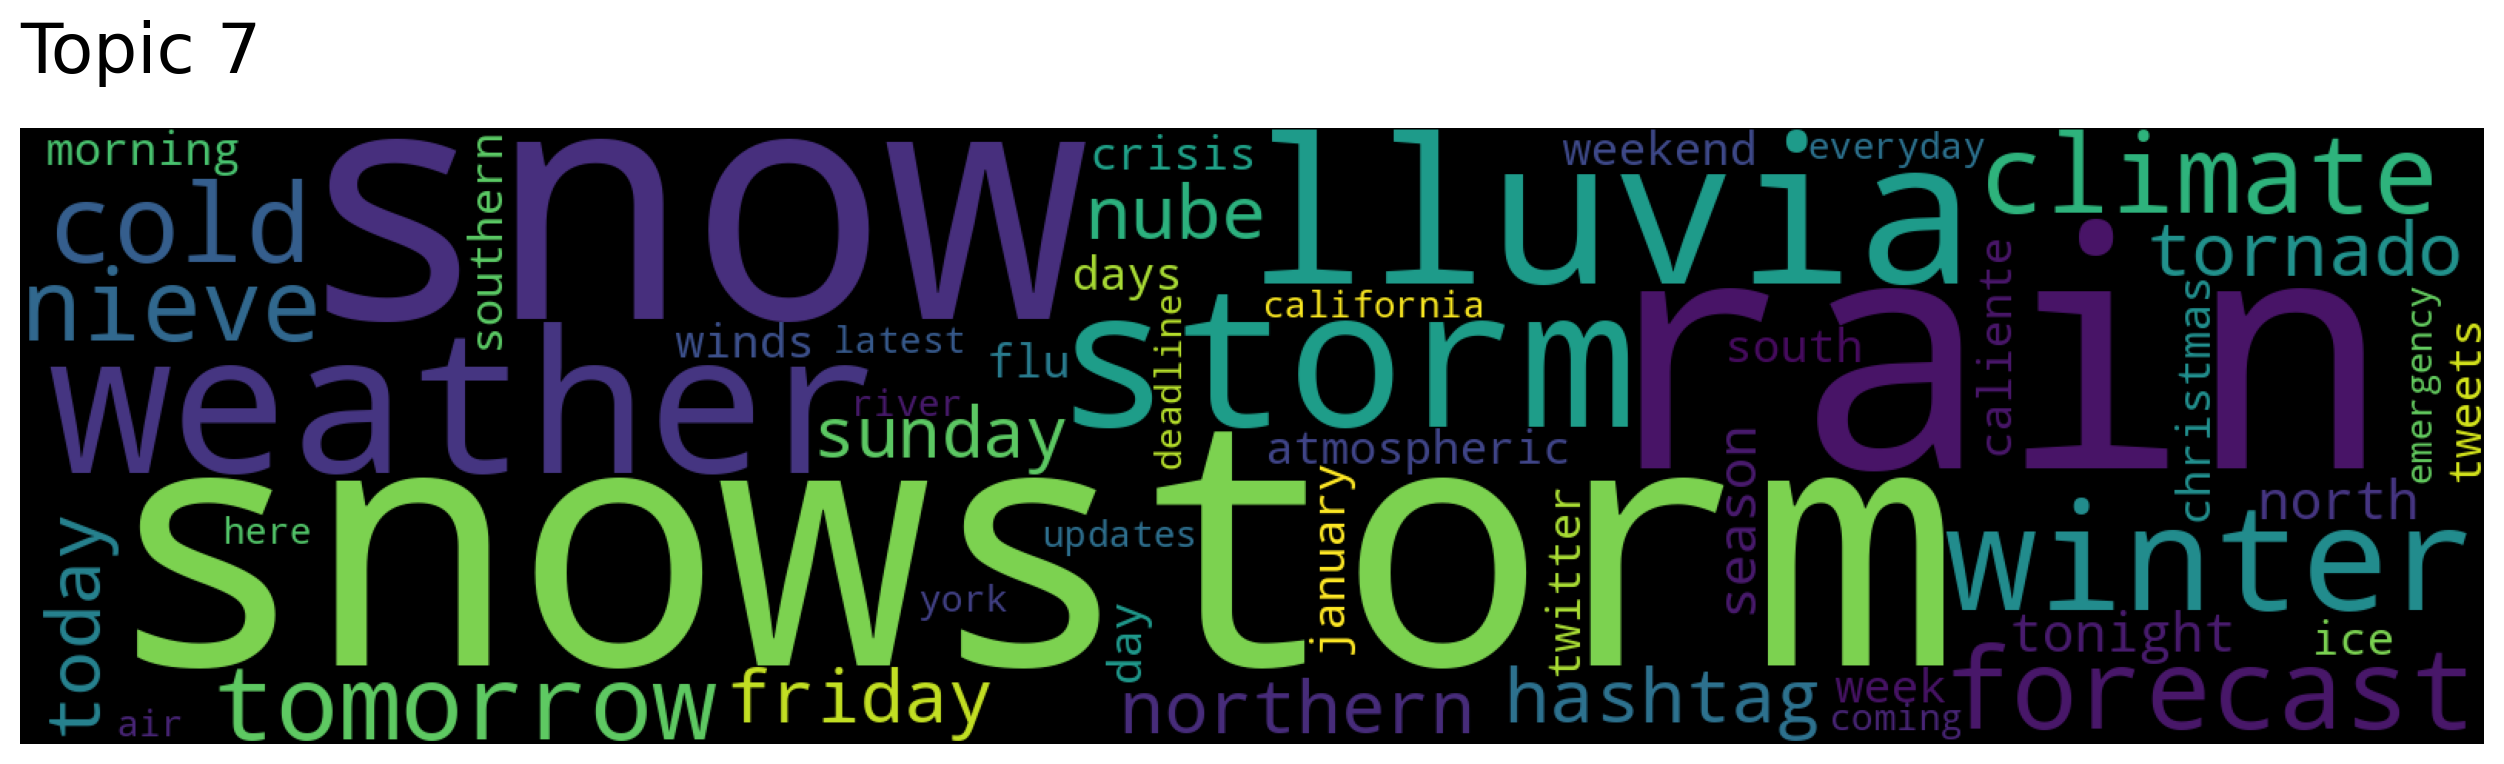

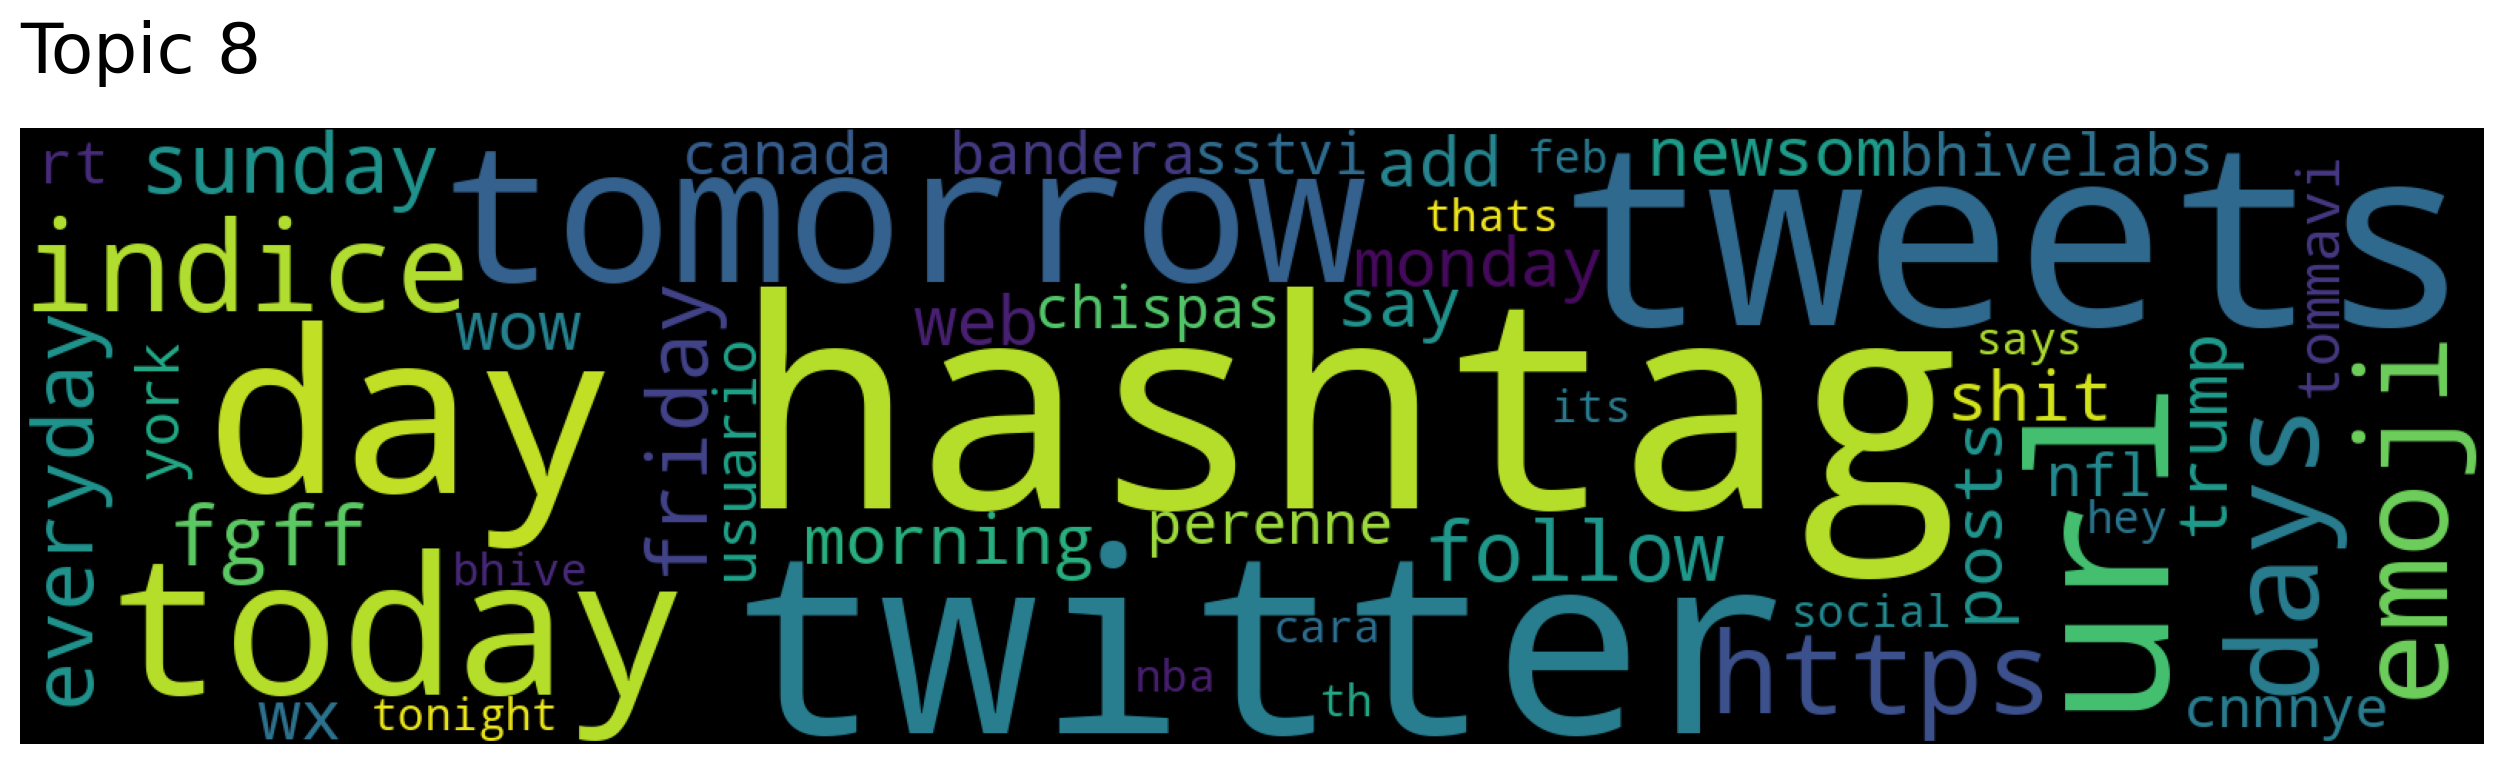

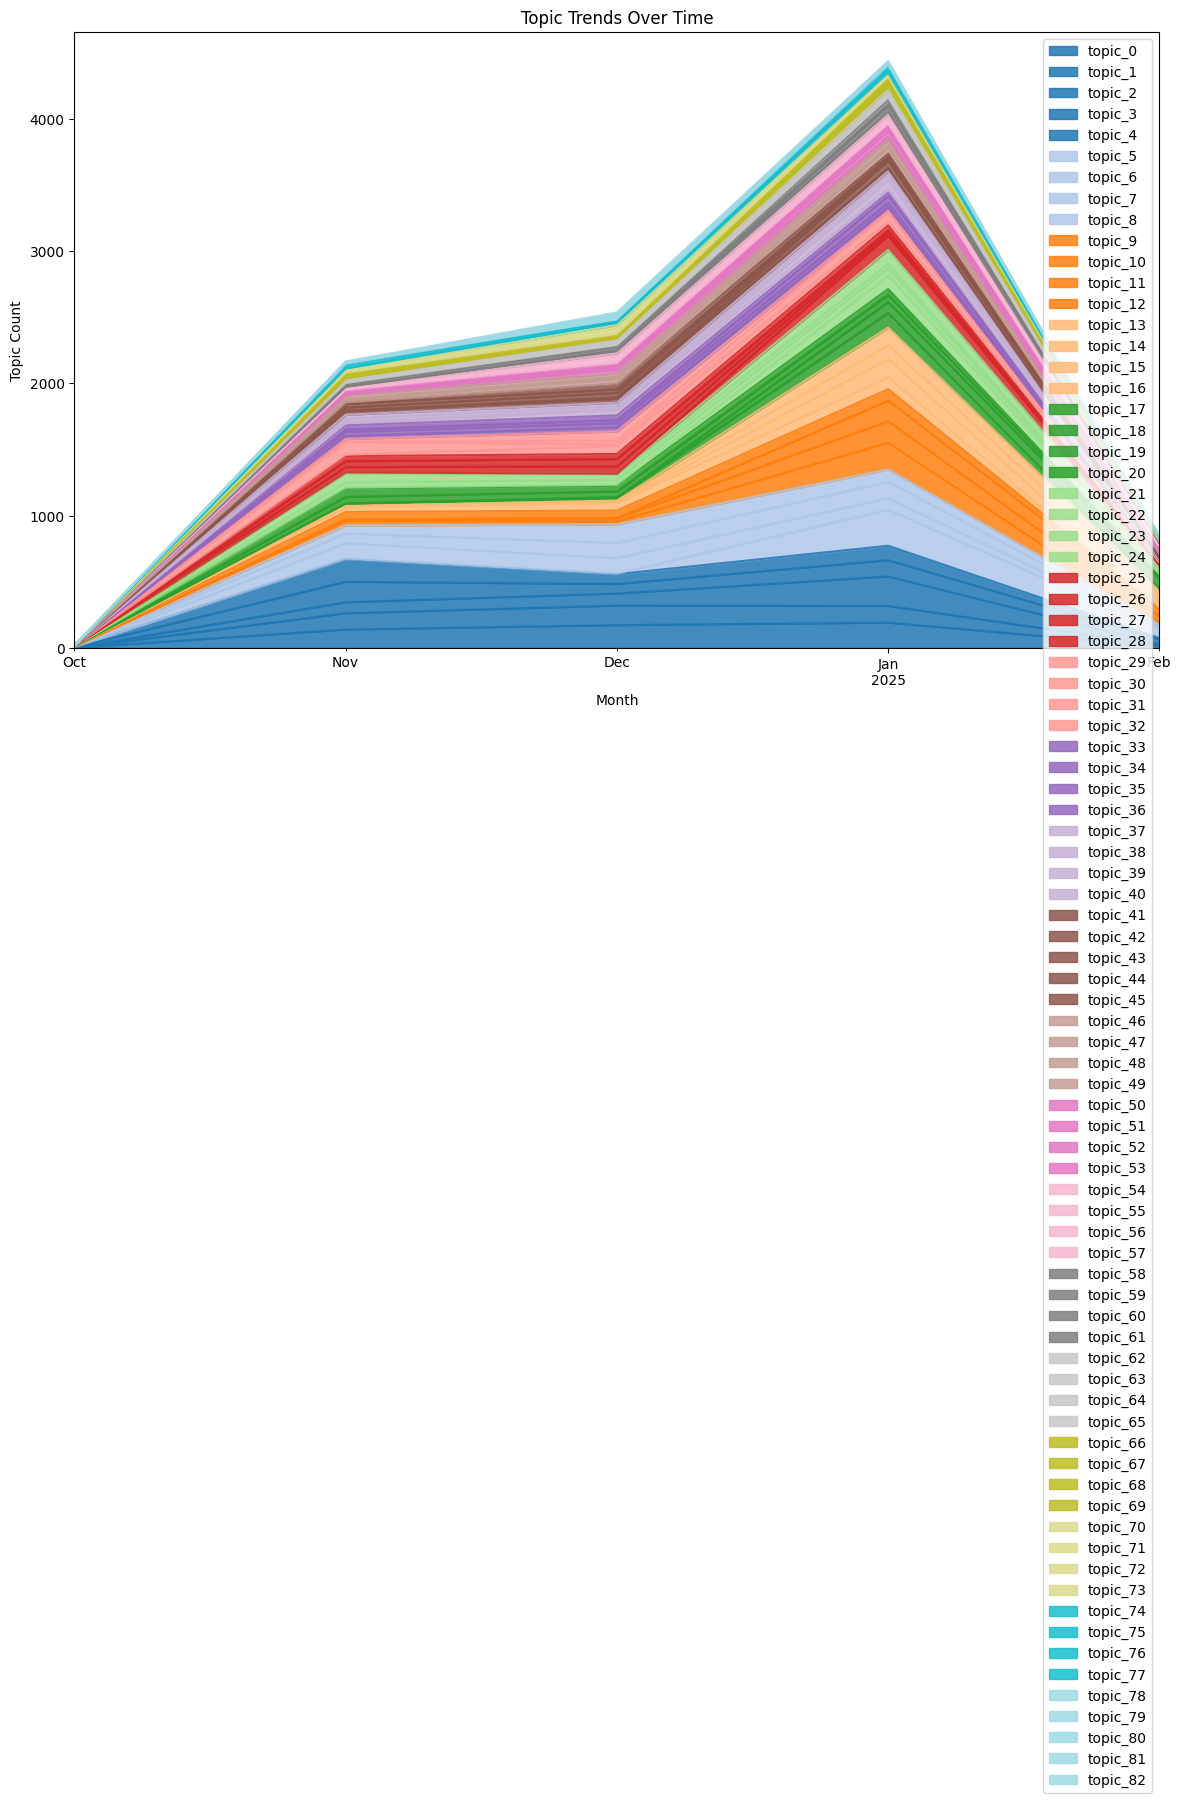

In [71]:
if __name__ == "__main__":
    main()
